# Creating the dataset from MaNGa

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from astropy.io import fits

### Loading the data

In [4]:
manga_dataset = fits.open('./raw_data/SDSSDR17_MaNGA_JAM.fits')
Yang07 = np.genfromtxt('./raw_data/MaNGA_MPL11_Yang07.cat', dtype=None, skip_header=4, encoding='utf-8')
manga_M2L_SPS = np.genfromtxt('./raw_data/MaNGA_SPS_M2L.txt', dtype=None, skip_header=1)
loct = Yang07['f12']

In [5]:
Plate_IFU = manga_dataset[1].data['plateifu']
manga_ID = manga_dataset[1].data['mangaid']

loct = Yang07['f12']
Qual = manga_dataset[1].data['Qual']
fDM = manga_dataset[8].data['fdm_Re']
M_stellar = manga_dataset[1].data['Lum_tot_MGE'] + manga_M2L_SPS - 0.25 # logMstellar [Msun] Chabrier IMF
Reff = manga_dataset[1].data['Re_kpc_MGE'] # Reff [kpc]

fdm_gNFW_cyl = manga_dataset[8].data['fdm_Re']
fdm_gNFW_sph = manga_dataset[9].data['fdm_Re']
Gt_gNFW_cyl = manga_dataset[8].data['MW_Gt_Re']
Gt_gNFW_sph = manga_dataset[9].data['MW_Gt_Re']

quality_flag_jam = (Qual>=1) & (np.abs(Gt_gNFW_cyl-Gt_gNFW_sph)<3*0.079) & (~np.isnan(Gt_gNFW_cyl))
quality_flag_fdm = np.abs(fdm_gNFW_cyl-fdm_gNFW_sph) < 0.10
quality_flag_all = quality_flag_jam & (loct==1) & (~np.isnan(M_stellar)) & quality_flag_fdm

fDM = fDM[quality_flag_all]
M_stellar = 10**M_stellar[quality_flag_all]
Qual = Qual[quality_flag_all]
Reff = Reff[quality_flag_all]
Plate_IFU = Plate_IFU[quality_flag_all]
manga_ID = manga_ID[quality_flag_all]
num_sample = len(M_stellar)

In [6]:
manga_dataset.close()

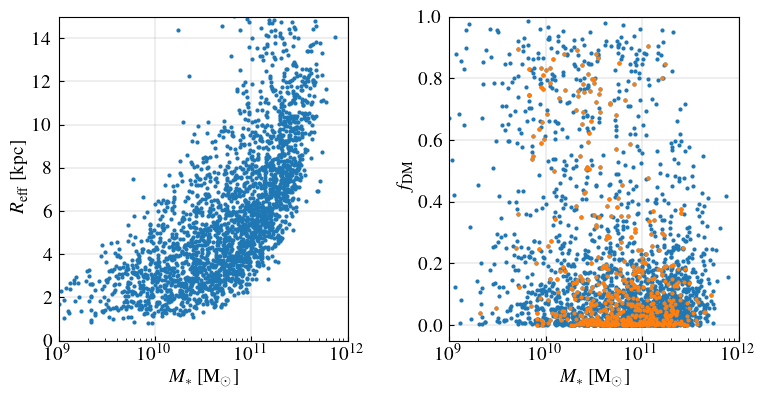

In [8]:
#################
# Plot parameters
params = {
    "font.size": 14,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (8, 4),
    "figure.subplot.left": 0.12,
    "figure.subplot.right": 0.97,
    "figure.subplot.bottom": 0.12,
    "figure.subplot.top": 0.93,
    "figure.subplot.wspace": 0.35,
    "figure.subplot.hspace": 0.35,
    "lines.markersize": 2,
    "lines.linewidth": 1,
    "figure.max_open_warning": 0,
}
plt.rcParams.update(params)
plt.figure()
ax = plt.subplot(1, 2, 1)
plt.grid(linestyle='-', linewidth=0.3)
plt.plot(M_stellar, Reff, 'o')
plt.axis([1e9, 1e12, 0, 15])
plt.xscale('log')
plt.ylabel(r"$R_{\mathrm{eff}}$ [kpc]")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)

ax = plt.subplot(1, 2, 2)
plt.grid(linestyle='-', linewidth=0.3)
plt.plot(M_stellar, fDM, 'o')
plt.plot(M_stellar[Qual>2], fDM[Qual>2], 'o')

plt.axis([1e9, 1e12, -0.05, 1])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.show()

### Making the final csv file

In [6]:
# Writing the data into a CSV file
with open('dataset/MANGA.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow(["PlateIFU", "MaNGAID", "M*[Msun]", "fDM(Reff)", "Reff[kpc]", "QualityFlag"])

    # Looping through each element of the data
    for i in range(num_sample):

        Mi = M_stellar[i]
        fDMi = fDM[i]
        Qi = Qual[i]
        Ri = Reff[i]
        Plate_i = Plate_IFU[i]
        ID_i = manga_ID[i]

        
        # Writing the data into the CSV file
        writer.writerow([Plate_i, ID_i, Mi, fDMi, Ri, Qi])

In [7]:
# Reading the CSV file into a DataFrame
manga = pd.read_csv('dataset/MANGA.csv')
manga

,PlateIFU,MaNGAID,M*[Msun],fDM(Reff),Reff[kpc],QualityFlag
0,7443-3702,12-84670,2.111882e+11,0.253,6.848,2
1,7443-12705,12-84627,3.337476e+10,0.878,8.482,3
2,7495-12704,12-129618,5.712607e+10,0.910,6.942,1
3,7495-12701,12-192120,8.945109e+10,0.020,6.312,1
4,7495-12703,12-129646,2.668318e+10,0.514,5.917,3
...,...,...,...,...,...,...
2533,11967-12702,1-335446,8.431582e+09,0.089,4.127,1
2534,12675-1902,1-211368,6.756039e+10,0.065,3.640,1
2535,11981-9102,1-294090,2.908872e+10,0.951,5.939,1
2536,12682-3703,1-212396,3.809425e+11,0.075,11.045,3
